In [8]:
# READING USERS DF

import pandas as pd
import numpy as np
import os
os.chdir("c://Users//gufer//OneDrive//Documentos//FIAP//Fase_05//ML_Engineer_Datathon/")

In [9]:
target = pd.read_parquet("data/features/target.parquet")
target.columns
#target["coldStart"].value_counts(normalize=True)

Index(['userId', 'pageId', 'TARGET'], dtype='object')

In [10]:
mix_df = pd.read_parquet("data/features/mix_feats/mix_df.parquet")

In [11]:
mix_df["coldStart"].value_counts(normalize=True)

coldStart
False    0.920591
True     0.079409
Name: proportion, dtype: float64

In [12]:
suggested_feats = pd.read_parquet("data/features/suggested_feats.parquet")
suggested_feats["coldStart"].value_counts(normalize=True)

coldStart
False    0.920591
True     0.079409
Name: proportion, dtype: float64

In [13]:
users = pd.read_parquet("data/features/users_feats.parquet")
df_users = users

In [14]:
df_users["coldStart"].value_counts(normalize=True)

coldStart
False    0.920591
True     0.079409
Name: proportion, dtype: float64

In [15]:
df_users["userId"].nunique()

57794

In [16]:
def create_target(df_users: pd.DataFrame) -> pd.DataFrame:
    """Gera a coluna TARGET padronizada de forma menos sensível a outliers (robust scaling)."""
    
    # Agrega usando diferentes estratégias de agrupamento
    agg_df = df_users.groupby('userId', as_index=False).agg({
        'numberOfClicksHistory': 'sum',
        'timeOnPageHistory': 'sum',
        'scrollPercentageHistory': 'mean',
        'pageVisitsCountHistory': 'sum',
        'minutesSinceLastVisit': 'mean'
    })
    
    # Aplica transformação logarítmica para reduzir a influência de outliers
    agg_df['pageVisitsTransformed'] = np.log1p(agg_df['pageVisitsCountHistory'])
    
    # Cálculo do TARGET com pesos ajustados, usando a versão transformada de pageVisitsCountHistory
    agg_df['TARGET'] = (
        agg_df['numberOfClicksHistory'] +
        1.5 * (agg_df['timeOnPageHistory'] / 500) +
        agg_df['scrollPercentageHistory'] +
        2 * agg_df['pageVisitsTransformed'] -
        (agg_df['minutesSinceLastVisit'] / 20)
    )
    
    # Calcula a mediana dos valores de 'TARGET'
    median_val = agg_df['TARGET'].median()

    # Calcula o intervalo interquartil (IQR)
    iqr_val = agg_df['TARGET'].quantile(0.75) - agg_df['TARGET'].quantile(0.25)

    # Se o IQR for zero (todos os valores iguais, por exemplo), apenas subtrai a mediana
    # Caso contrário, padroniza (robust scaling) subtraindo a mediana e dividindo pelo IQR
    if iqr_val == 0:
        agg_df['TARGET'] = agg_df['TARGET'] - median_val
    else:
        agg_df['TARGET'] = (agg_df['TARGET'] - median_val) / iqr_val

    # Mescla os valores padronizados de 'TARGET' de volta ao DataFrame original
    target_df = df_users.merge(agg_df[['userId', 'TARGET']], on='userId', how='left')

    return target_df

target_df = create_target(df_users)
target_df

,userId,userType,historySize,pageId,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory,minutesSinceLastVisit,timestampHistoryDate,timestampHistoryTime,timestampHistoryWeekday,timestampHistoryHour,isWeekend,dayPeriod,coldStart,TARGET
0,00011b1ced626112372206634e0e9b5ccb432da916e83f...,Non-Logged,1,c9b148e7-72fa-416e-84ac-a4499abc7aaf,0,14071,23.46,1,0.0,2022-07-26,14:10:06,1,14,False,afternoon,True,-0.190421
1,00012cd490cea9fe043146807def18c830fa0d0b791772...,Non-Logged,3,5a5e2555-ac88-4882-9dc2-e19bb392a448,0,50000,56.08,1,0.0,2022-07-31,19:44:24,6,19,True,night,True,0.166289
2,00012cd490cea9fe043146807def18c830fa0d0b791772...,Non-Logged,3,3363b054-df39-4e3d-b2b3-dd3cb227dd55,0,52647,59.64,1,1.0,2022-07-31,19:45:52,6,19,True,night,True,0.166289
3,00012cd490cea9fe043146807def18c830fa0d0b791772...,Non-Logged,3,e81de120-5005-4a01-8b63-90018005903e,0,60000,42.28,1,34.0,2022-07-31,20:19:50,6,20,True,night,True,0.166289
4,00024d84a3d619b1972e9dd5efa9c930557d85f6463fd6...,Logged,1,c274ed4b-e679-41ce-9dfb-c53874916511,11,32436,46.58,1,0.0,2022-07-30,18:58:05,5,18,True,night,True,-0.123527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808073,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,Non-Logged,26,fb5459eb-d86b-447e-83d5-0172fbab1ecd,0,10000,39.53,1,13.0,2022-08-06,01:28:47,5,1,True,dawn,False,3.668507
808074,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,Non-Logged,26,2e3300c6-3a18-4908-b9a9-a955cfcdcfcc,0,50000,34.46,2,5716.0,2022-08-10,00:44:20,2,0,False,dawn,False,3.668507
808075,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,Non-Logged,26,1ca0b64a-8bb4-4a2b-b3d0-af935960bf15,0,10000,7.05,1,619.0,2022-08-10,11:03:12,2,11,False,morning,False,3.668507
808076,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,Non-Logged,26,331bc28e-4e05-425e-8914-766606dfdf88,0,50000,21.99,1,1178.0,2022-08-11,06:40:54,3,6,False,morning,False,3.668507


In [17]:
# Target: ENGAGEMENT_SCORE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_target_distribution(df):
    """Plota a distribuição da variável TARGET."""
    plt.figure(figsize=(10, 5))
    sns.histplot(df['TARGET'], bins=50, kde=True)
    plt.xlabel('TARGET (Engajamento Padronizado)')
    plt.ylabel('Frequência')
    plt.title('Distribuição da Variável TARGET')
    plt.grid(True)
    plt.show()

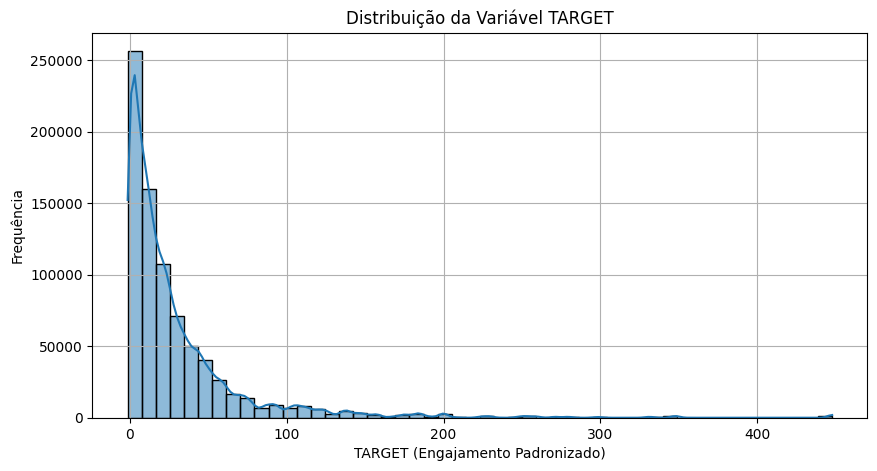

In [18]:
plot_target_distribution(target_df)

In [19]:
TARGET_INIT_COLS = [
    "userId", 
    "pageId",
    "numberOfClicksHistory",
    "timeOnPageHistory",
    "coldStart",
    "scrollPercentageHistory",
    "minutesSinceLastVisit",
    "timeGapDays"
]

TARGET_FINAL_COLS = [
    "userId", 
    "pageId",
    "TARGET"
]

In [20]:
def preprocess_target(
    df_users: pd.DataFrame,
    gap_df: pd.DataFrame
) -> pd.DataFrame:
    """Gera a coluna TARGET para medir engajamento por usuário/página, considerando o gap de tempo"""
    
    # Mescla os DataFrames com base em userId e pageId
    target_df = df_users.merge(gap_df, on=["userId", "pageId"])[TARGET_INIT_COLS]
    
    # Calcula um score base de engajamento usando as métricas históricas do usuário
    base_score = (
        target_df['numberOfClicksHistory']
        + (target_df['timeOnPageHistory'] / 500)
        + target_df['scrollPercentageHistory']
        - (target_df['minutesSinceLastVisit'] / 50)
    )
    
    # Fator multiplicativo que penaliza usuários que demoram muito para ver notícias (menos engajados)
    gap_factor = 1 / (1 + target_df['timeGapDays'])
    
    # Calcula o TARGET combinando o score base com o fator de gap
    target_df['TARGET'] = base_score * gap_factor
    
    # Padroniza TARGET utilizando robust scaling (subtrai a mediana e divide pelo IQR)
    median_val = target_df['TARGET'].median()
    iqr_val = target_df['TARGET'].quantile(0.75) - target_df['TARGET'].quantile(0.25)
    
    if iqr_val == 0:
        target_df['TARGET'] = target_df['TARGET'] - median_val
    else:
        target_df['TARGET'] = (target_df['TARGET'] - median_val) / iqr_val
    
    # Mantém só as colunas essenciais do dataframe de target
    target_df = target_df[TARGET_FINAL_COLS]
    
    return target_df

gap = pd.read_parquet("data/features/mix_feats/gap_feats.parquet")

target_new = preprocess_target(df_users, gap)
target_new

,userId,pageId,TARGET
0,00011b1ced626112372206634e0e9b5ccb432da916e83f...,c9b148e7-72fa-416e-84ac-a4499abc7aaf,-0.354646
1,00012cd490cea9fe043146807def18c830fa0d0b791772...,5a5e2555-ac88-4882-9dc2-e19bb392a448,8.666845
2,00012cd490cea9fe043146807def18c830fa0d0b791772...,3363b054-df39-4e3d-b2b3-dd3cb227dd55,-0.076096
3,00012cd490cea9fe043146807def18c830fa0d0b791772...,e81de120-5005-4a01-8b63-90018005903e,-0.348626
4,00024d84a3d619b1972e9dd5efa9c930557d85f6463fd6...,c274ed4b-e679-41ce-9dfb-c53874916511,-0.335565
...,...,...,...
474665,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,fb5459eb-d86b-447e-83d5-0172fbab1ecd,-0.166146
474666,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,2e3300c6-3a18-4908-b9a9-a955cfcdcfcc,-0.313386
474667,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,1ca0b64a-8bb4-4a2b-b3d0-af935960bf15,-0.329151
474668,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,331bc28e-4e05-425e-8914-766606dfdf88,-0.352126


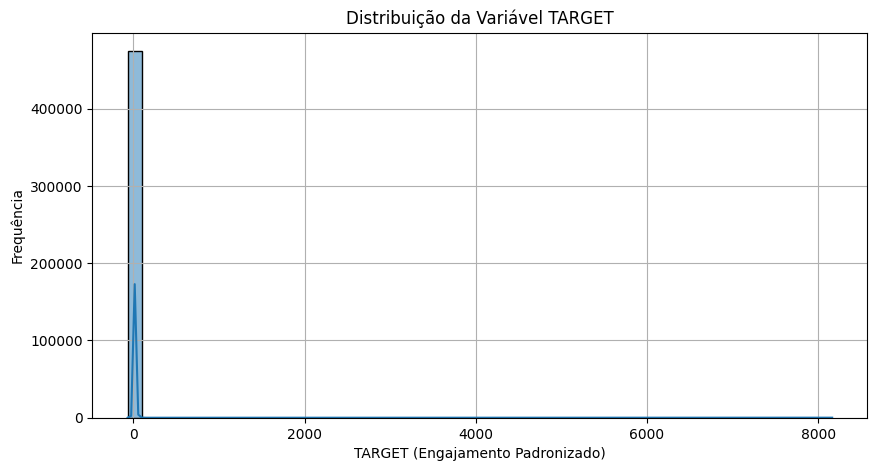

In [21]:
plot_target_distribution(target_new)

In [22]:
final_feats_with_target = pd.read_parquet("data/features/final_feats_with_target.parquet")
final_feats_with_target.columns

Index(['userId', 'pageId', 'userType', 'isWeekend', 'dayPeriod',
       'issuedDatetime', 'timestampHistoryDatetime', 'coldStart', 'localState',
       'localRegion', 'themeMain', 'themeSub', 'relLocalState',
       'relLocalRegion', 'relThemeMain', 'relThemeSub', 'TARGET'],
      dtype='object')

In [23]:
final_feats_with_target["localState"].value_counts()

localState
sp    136674
rj    116158
mg     35362
pr     31223
go     25613
sc     21567
df     19809
ba     18376
ms     12868
pe     12657
rs     10987
ce     10017
pi      6755
to      6301
pa      5584
mt      5445
es      5085
pb      4525
rn      3786
am      3570
ma      3107
ac      2983
ro      2657
al      2328
ap      2137
rr      1835
se      1494
Name: count, dtype: int64

In [24]:
final_feats_with_target["userId"].shape, final_feats_with_target[["userId","pageId"]].nunique()

((808078,),
 userId    57794
 pageId    80208
 dtype: int64)

In [25]:
final_feats_with_target["coldStart"].value_counts(normalize=True)

coldStart
False    0.920591
True     0.079409
Name: proportion, dtype: float64

In [26]:
final_feats_with_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808078 entries, 0 to 808077
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   userId                    808078 non-null  object        
 1   pageId                    808078 non-null  object        
 2   userType                  808078 non-null  category      
 3   isWeekend                 808078 non-null  bool          
 4   dayPeriod                 808078 non-null  category      
 5   issuedDatetime            808078 non-null  datetime64[ns]
 6   timestampHistoryDatetime  808078 non-null  datetime64[ns]
 7   coldStart                 808078 non-null  bool          
 8   localState                508903 non-null  object        
 9   localRegion               508903 non-null  object        
 10  themeMain                 302121 non-null  object        
 11  themeSub                  82834 non-null   object        
 12  re

In [27]:
final_feats_with_target.describe()

,issuedDatetime,timestampHistoryDatetime,relLocalState,relLocalRegion,relThemeMain,relThemeSub,TARGET
count,808078,808078,508903.000000,508903.000000,302121.000000,82834.000000,4.746700e+05
mean,2022-05-11 04:16:29.391598336,2022-07-24 04:20:58.840935936,0.258464,0.209481,0.163418,0.153221,6.656062e-01
min,2014-07-31 08:00:01,2022-07-01 03:00:19,0.000488,0.000488,0.000488,0.000488,-6.637986e+00
25%,2022-07-07 13:21:10,2022-07-13 00:29:19.500000,0.059226,0.033333,0.037037,0.017964,-2.859980e-01
50%,2022-07-20 12:29:21,2022-07-24 14:34:32,0.165605,0.100000,0.083333,0.044444,-2.739857e-17
75%,2022-08-02 14:44:28,2022-08-04 03:06:32.249999872,0.333333,0.257426,0.166667,0.125000,7.140020e-01
max,2022-08-15 02:21:37,2022-08-15 02:59:30,1.000000,1.000000,1.000000,1.000000,2.289034e+03
std,NaN,NaN,0.272911,0.262758,0.229264,0.261665,6.495731e+00


In [28]:
gap_df = pd.read_parquet("data/features/mix_feats/gap_feats.parquet")

In [29]:
TARGET_INIT_COLS = [
    "userId", 
    "pageId",
    "historySize",
    "numberOfClicksHistory",
    "timeOnPageHistory",
    "scrollPercentageHistory",
    "minutesSinceLastVisit",
    "timeGapDays",
]

# Mescla os DataFrames com base em userId e pageId
target_df = df_users.merge(gap_df, on=["userId", "pageId"])[TARGET_INIT_COLS]
target_df.describe()

,historySize,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,minutesSinceLastVisit,timeGapDays
count,474670.000000,474670.000000,4.746700e+05,474670.000000,474670.000000,474670.000000
mean,133.006415,11.270700,8.499108e+04,48.077780,1417.733643,139.467674
std,207.323993,37.702277,9.906745e+04,1139.131471,4419.234375,344.945100
min,1.000000,0.000000,5.000000e+03,0.240000,0.000000,0.000000
25%,20.000000,0.000000,2.681100e+04,25.870000,2.000000,10.000000
50%,72.000000,1.000000,5.785400e+04,42.450000,43.000000,24.000000
75%,163.000000,12.000000,1.100000e+05,59.360000,978.000000,41.000000
max,2051.000000,13476.000000,1.022495e+07,423621.910000,63703.000000,2894.000000


In [30]:
X_train = pd.read_parquet("data/train/X_train.parquet")
y_train = pd.read_parquet("data/train/y_train.parquet")
X_train.columns

Index(['isWeekend', 'relLocalState', 'relLocalRegion', 'relThemeMain',
       'relThemeSub', 'userTypeFreq', 'dayPeriodFreq', 'localStateFreq',
       'localRegionFreq', 'themeMainFreq', 'themeSubFreq'],
      dtype='object')

In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556860 entries, 0 to 1556859
Data columns (total 11 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   isWeekend        1556860 non-null  bool   
 1   relLocalState    1523901 non-null  float64
 2   relLocalRegion   1523901 non-null  float64
 3   relThemeMain     685315 non-null   float64
 4   relThemeSub      610697 non-null   float64
 5   userTypeFreq     1556860 non-null  float64
 6   dayPeriodFreq    1556860 non-null  float64
 7   localStateFreq   1523901 non-null  float64
 8   localRegionFreq  1523901 non-null  float64
 9   themeMainFreq    685315 non-null   float64
 10  themeSubFreq     610697 non-null   float64
dtypes: bool(1), float64(10)
memory usage: 120.3 MB


In [32]:
def feature_selection(
    suggested_feats, 
    df_target, 
    target_col='TARGET', 
    method="correlation", 
    drop_cols=None, 
    threshold=0.95, 
    k_best=10):
    """
    Realiza a seleção de features no dataframe suggested_feats.

    Parâmetros:
        suggested_feats (DataFrame): DataFrame com as features finais.
        df_target (DataFrame): DataFrame contendo o target.
        target_col (str): String com a coluna alvo de engajamento (variável dependente).
        method (str): Método de seleção. Pode ser:
                      - "correlation": remove features altamente correlacionadas.
                      - "univariate": seleciona as k melhores features via teste univariado (ANOVA).
        drop_cols (list): Lista de colunas a serem descartadas antes da seleção (ex.: identificadores).
        threshold (float): Limite de correlação para remoção de features redundantes (método "correlation").
        k_best (int): Número de melhores features a serem selecionadas (método "univariate").

    Retorna:
        DataFrame: DataFrame com as features selecionadas e a coluna target_col.
    """
    COR_COLS = [
        'localState', 'localRegion', 'themeMain', 'themeSub',
        'countLocalStateUser', 'relLocalState', 'countLocalRegionUser',
        'relLocalRegion', 'countThemeMainUser', 'relThemeMain',
        'countThemeSubUser', 'relThemeSub'
    ]
    # Remove as colunas que não são consideradas para o processo de seleção
    if drop_cols is not None:
        df = df.drop(columns=drop_cols)
    
    # Separa as variáveis preditoras (X) e a variável alvo (y)
    X = suggested_feats[COR_COLS]
    y = df_target
    
    if method == "correlation":
        # Calcula a matriz de correlação entre as features
        corr_matrix = X.corr().abs()
        # Considera apenas a parte superior da matriz para evitar redundância
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        # Identifica features que possuem alta correlação com alguma outra feature
        drop_features = [col for col in upper_tri.columns if any(upper_tri[col] > threshold)]
        X_selected = X.drop(columns=drop_features)
        print(f"Features removidas por alta correlação: {drop_features}")
        return pd.concat([X_selected, y], axis=1)
    
    elif method == "univariate":
        # Seleção univariada utilizando o teste F (ANOVA) para regressão/classificação
        selector = SelectKBest(score_func=f_classif, k=k_best)
        selector.fit(X, y)
        mask = selector.get_support()  # Máscara booleana das features selecionadas
        selected_features = X.columns[mask]
        print(f"Features selecionadas pelo método univariado: {list(selected_features)}")
        X_selected = X[selected_features]
        return pd.concat([X_selected, y], axis=1)
    
    else:
        raise ValueError("Método de seleção desconhecido. Escolha 'correlation' ou 'univariate'.")

In [33]:
X_train.describe()

,relLocalState,relLocalRegion,relThemeMain,relThemeSub,userTypeFreq,dayPeriodFreq,localStateFreq,localRegionFreq,themeMainFreq,themeSubFreq
count,1.523901e+06,1.523901e+06,685315.000000,610697.000000,1.556860e+06,1.556860e+06,1.523901e+06,1.523901e+06,685315.000000,610697.000000
mean,6.591969e-01,5.864880e-01,0.080817,0.069814,7.697491e-01,3.863390e-01,2.307068e-01,2.050989e-01,0.496129,0.602736
std,2.016663e-01,2.282084e-01,0.129582,0.106768,2.492188e-01,1.752946e-01,1.678566e-01,1.863434e-01,0.263101,0.266446
min,4.444444e-03,4.444444e-03,0.004444,0.004444,1.327473e-01,3.387845e-02,1.627402e-04,6.562106e-07,0.000001,0.000002
25%,7.027027e-01,5.454545e-01,0.054054,0.054054,8.672527e-01,2.164254e-01,7.202568e-02,2.936411e-02,0.197864,0.753636
50%,7.027027e-01,7.027027e-01,0.054054,0.054054,8.672527e-01,5.441543e-01,1.655527e-01,1.254760e-01,0.675038,0.753636
75%,7.362637e-01,7.027027e-01,0.054054,0.054054,8.672527e-01,5.441543e-01,4.204276e-01,4.204276e-01,0.675038,0.753636
max,1.000000e+00,1.000000e+00,1.000000,1.000000,8.672527e-01,5.441543e-01,4.204276e-01,4.204276e-01,0.675038,0.753636


In [34]:
feature_selection(X_train, y_train)

KeyError: "['localState', 'localRegion', 'themeMain', 'themeSub', 'countLocalStateUser', 'countLocalRegionUser', 'countThemeMainUser', 'countThemeSubUser'] not in index"

In [ ]:
y_train

,TARGET
252081,3.860478
1387706,0.108736
2113593,1.721917
165983,2.110034
832021,0.125647
...,...
732180,25.220086
110268,2.785324
1692743,-0.035535
2229084,2.214242


In [ ]:
X_train

,userType,issuedDatetime,timestampHistoryDatetime,coldStart,localState,localRegion,themeMain,themeSub,countLocalStateUser,relLocalState,countLocalRegionUser,relLocalRegion,countThemeMainUser,relThemeMain,countThemeSubUser,relThemeSub
252081,0.865458,2022-07-15 18:47:28,2022-07-28 23:24:04,False,0.165577,0.021661,NaN,NaN,35.0,0.155556,5.0,0.022222,NaN,NaN,NaN,NaN
1387706,0.865458,2021-11-04 16:20:13,2022-07-14 14:26:06,False,0.125361,0.125361,NaN,NaN,57.0,0.721519,57.0,0.721519,NaN,NaN,NaN,NaN
2113593,0.865458,2022-07-12 11:31:48,2022-08-04 19:50:44,False,0.125361,0.125361,NaN,NaN,55.0,0.753425,55.0,0.753425,NaN,NaN,NaN,NaN
165983,0.865458,2022-07-08 11:51:02,2022-08-09 17:54:45,False,0.047471,0.047471,NaN,NaN,55.0,0.597826,55.0,0.597826,NaN,NaN,NaN,NaN
832021,0.865458,2021-07-27 19:43:19,2022-07-25 14:29:23,False,0.419648,0.419648,NaN,NaN,78.0,0.702703,78.0,0.702703,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732180,0.865458,2022-07-12 17:30:56,2022-07-21 14:54:19,False,0.419648,0.419648,0.673248,0.752798,78.0,0.702703,78.0,0.702703,6.0,0.054054,6.0,0.054054
110268,0.865458,2022-04-20 14:18:02,2022-07-12 23:05:41,False,0.047471,0.047471,NaN,NaN,55.0,0.597826,55.0,0.597826,NaN,NaN,NaN,NaN
1692743,0.865458,2022-07-26 16:53:25,2022-07-26 18:47:34,False,0.029511,0.029511,NaN,NaN,19.0,0.791667,19.0,0.791667,NaN,NaN,NaN,NaN
2229084,0.134542,2022-07-17 10:27:06,2022-07-24 10:03:57,False,0.072237,0.004236,NaN,NaN,1.0,0.066667,1.0,0.066667,NaN,NaN,NaN,NaN


In [ ]:
encoder_mapping = pd.read_parquet("data/processed_data/train/encoder_mapping.parquet")
encoder_mapping.tail(100)

,userType,localState,localRegion,themeMain,themeSub
a-vida-e-pra-ja,NaN,NaN,NaN,NaN,0.000010
variola-dos-macacos,NaN,NaN,NaN,NaN,0.000010
em-movimento,NaN,NaN,NaN,NaN,0.000010
metronorte,NaN,NaN,NaN,NaN,0.000008
sebrae-ms,NaN,NaN,NaN,NaN,0.000008
...,...,...,...,...,...
algar-90-anos,NaN,NaN,NaN,NaN,0.000002
le-biscuit,NaN,NaN,NaN,NaN,0.000002
albert-sabin-hospital-e-maternidade-de-atibaia,NaN,NaN,NaN,NaN,0.000002
colegio-atrio,NaN,NaN,NaN,NaN,0.000002
